## Historic Drought Analysis

This notebook steps through an analysis of droughts in the DRB, assessing droughts using multiple different metrics including:
- Exceedance probability
- Severity
- Duration

Droughts are classified using the Standardized Streamflow Index (SSI).

In [24]:
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scipy.stats as scs
import spei as si

sys.path.insert(0, '../')

from methods.diagnostics.drought import get_drought_metrics, calculate_ssi_values
from methods.plotting import plot_ssi
from methods.plotting.styles import model_colors

from methods.processing import transform_results_dict_flow
from methods.processing.load import load_historic_datasets
from methods.utils.lists import drbc_droughts
from methods.utils.constants import crs


# Directory to pywrdrb project
pywrdrb_directory = '../../Pywr-DRB/'
sys.path.append(pywrdrb_directory)

from pywrdrb.pywr_drb_node_data import obs_pub_site_matches, upstream_nodes_dict
from pywrdrb.utils.lists import majorflow_list, reservoir_list


# Model generation specifications
full_date_range = ('1945-01-01', '2022-12-31')
nyc_reservoirs = ['cannonsville', 'pepacton', 'neversink']

model_names = ['obs', 'nhmv10', 'nwmv21', 
               'obs_pub_nhmv10_ObsScaled', 'obs_pub_nwmv21_ObsScaled',
               'obs_pub_nhmv10_ObsScaled_ensemble', 'obs_pub_nwmv21_ObsScaled_ensemble']


# Aesthetics for plotting
model_colors = {
    'obs': 'black',
    'nhmv10' : '#925736', 
    'nwmv21' : '#385723',
    'obs_pub_nhmv10' : '#F27300',
    'obs_pub_nhmv10_ObsScaled': '#F27300', 
    'obs_pub_nhmv10_ensemble' : '#F9B572', 
    'obs_pub_nhmv10_ObsScaled_ensemble' : '#F9B572', 
    'obs_pub_nwmv21' : '#0174BE', 
    'obs_pub_nwmv21_ensemble': '#9CD2F6',
    'obs_pub_nwmv21_ObsScaled' : '#0174BE', 
    'obs_pub_nwmv21_ObsScaled_ensemble': '#9CD2F6'
    }

model_labels = {
    'obs': 'Observed',
    'nhmv10' : 'NHMv1.0',
    'nwmv21' : 'NWMv2.1',
    'obs_pub_nhmv10' : 'PUB-NHM',
    'obs_pub_nhmv10_ensemble' : 'PUB-NHM Ensemble',
    'obs_pub_nwmv21' : 'PUB-NWM',
    'obs_pub_nwmv21_ensemble':'PUB-NWM Ensemble',
    'obs_pub_nhmv10_ObsScaled' : 'PUB-NHM',
    'obs_pub_nhmv10_ObsScaled_ensemble' : 'PUB-NHM Ensemble',
    'obs_pub_nwmv21_ObsScaled' : 'PUB-NWM',
    'obs_pub_nwmv21_ObsScaled_ensemble':'PUB-NWM Ensemble'
    }


In [46]:
### LOAD DATA
Q = load_historic_datasets(models=model_names)

# Load spatial data
drb_boundary = gpd.GeoDataFrame.from_file(f'{pywrdrb_directory}/DRB_spatial/DRB_shapefiles/drb_bnd_polygon.shp').to_crs(crs)
node_geoms = gpd.read_file(f'{pywrdrb_directory}/DRB_spatial/DRB_shapefiles/node_basin_geometries.shp').to_crs(crs)



Loading obs...
Loading nhmv10...
Loading nwmv21...
Loading obs_pub_nhmv10_ObsScaled...
Loading obs_pub_nwmv21_ObsScaled...
Loading obs_pub_nhmv10_ObsScaled_ensemble...
Loading obs_pub_nwmv21_ObsScaled_ensemble...


In [47]:
### Get SSI values
## Aggregate flows
Q_monthly = transform_results_dict_flow(Q.copy(), transform = 'aggregation',  window=0,
                       aggregation_type = 'sum', aggregation_length='M')

ssi_window = int(12)
ssi_d = calculate_ssi_values(Q_monthly, window=ssi_window, nodes=['delTrenton'])


Calculating SSI for obs...
Calculating SSI for nhmv10...
Calculating SSI for nwmv21...
Calculating SSI for obs_pub_nhmv10_ObsScaled...
Calculating SSI for obs_pub_nwmv21_ObsScaled...
Calculating SSI for obs_pub_nhmv10_ObsScaled_ensemble...
Calculating SSI for obs_pub_nwmv21_ObsScaled_ensemble...


In [48]:
Q['obs_pub_nhmv10_ObsScaled']

,cannonsville,pepacton,neversink,wallenpaupack,prompton,shoholaMarsh,mongaupeCombined,beltzvilleCombined,fewalter,merrillCreek,...,01433500,delMontague,01449800,01447800,delDRCanal,delTrenton,01463620,outletAssunpink,01470960,outletSchuylkill
datetime,,,,,,,,,,,,,,,,,,,,,
1945-01-01,2870.302413,2619.941124,465.889412,637.774664,60.050223,369.659844,366.365282,64.524423,252.050917,298.668421,...,1070.463580,17550.418346,91.022464,271.882672,25357.642761,25357.642761,75.495816,186.439377,366.467142,2959.600615
1945-01-02,2541.301566,2630.981919,506.790219,782.343847,91.205907,345.715862,365.774368,92.997350,415.739773,312.732080,...,1068.917479,17297.575719,137.732289,447.971332,26895.816501,26895.816501,94.145968,230.622004,399.891712,3285.650703
1945-01-03,1724.644750,1577.788129,258.292998,624.395361,66.856382,258.675750,205.443438,73.929783,339.684931,186.478548,...,522.597675,11810.140022,108.469718,364.363743,21320.083172,21320.083172,64.913401,154.524732,257.530294,2388.480173
1945-01-04,1303.749286,1258.035257,223.056366,541.309499,61.923730,205.515726,164.965661,72.002301,338.941874,138.528673,...,410.289889,10055.713239,106.076331,363.223113,18836.560808,18836.560808,52.852857,124.718809,237.060618,2220.216367
1945-01-05,958.623429,966.776186,196.114669,444.314754,53.652545,156.754475,130.648420,68.180637,321.952234,102.759012,...,323.985991,7697.898734,100.134833,344.675197,14118.235515,14118.235515,45.173093,105.294268,220.968875,1957.479243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,976.977619,799.953472,220.493912,382.910611,67.203806,133.445992,109.798800,113.866539,544.430252,35.863192,...,276.790007,7033.163039,155.782493,574.890221,12376.166924,12376.166924,33.964846,84.110846,286.813162,1643.003299
2022-12-28,850.435765,700.235415,197.761756,348.961046,62.228139,118.455630,96.461900,104.224713,464.127209,32.567172,...,245.398573,5960.515206,141.635668,491.334995,10725.566744,10725.566744,31.491542,82.015872,273.336049,1560.603783
2022-12-29,755.245528,626.425131,180.414943,319.205589,53.181473,105.415166,85.615292,96.416900,418.956555,30.565261,...,221.099982,5225.044103,130.352317,443.824280,9687.820675,9687.820675,31.363992,81.701653,257.609183,1512.447126


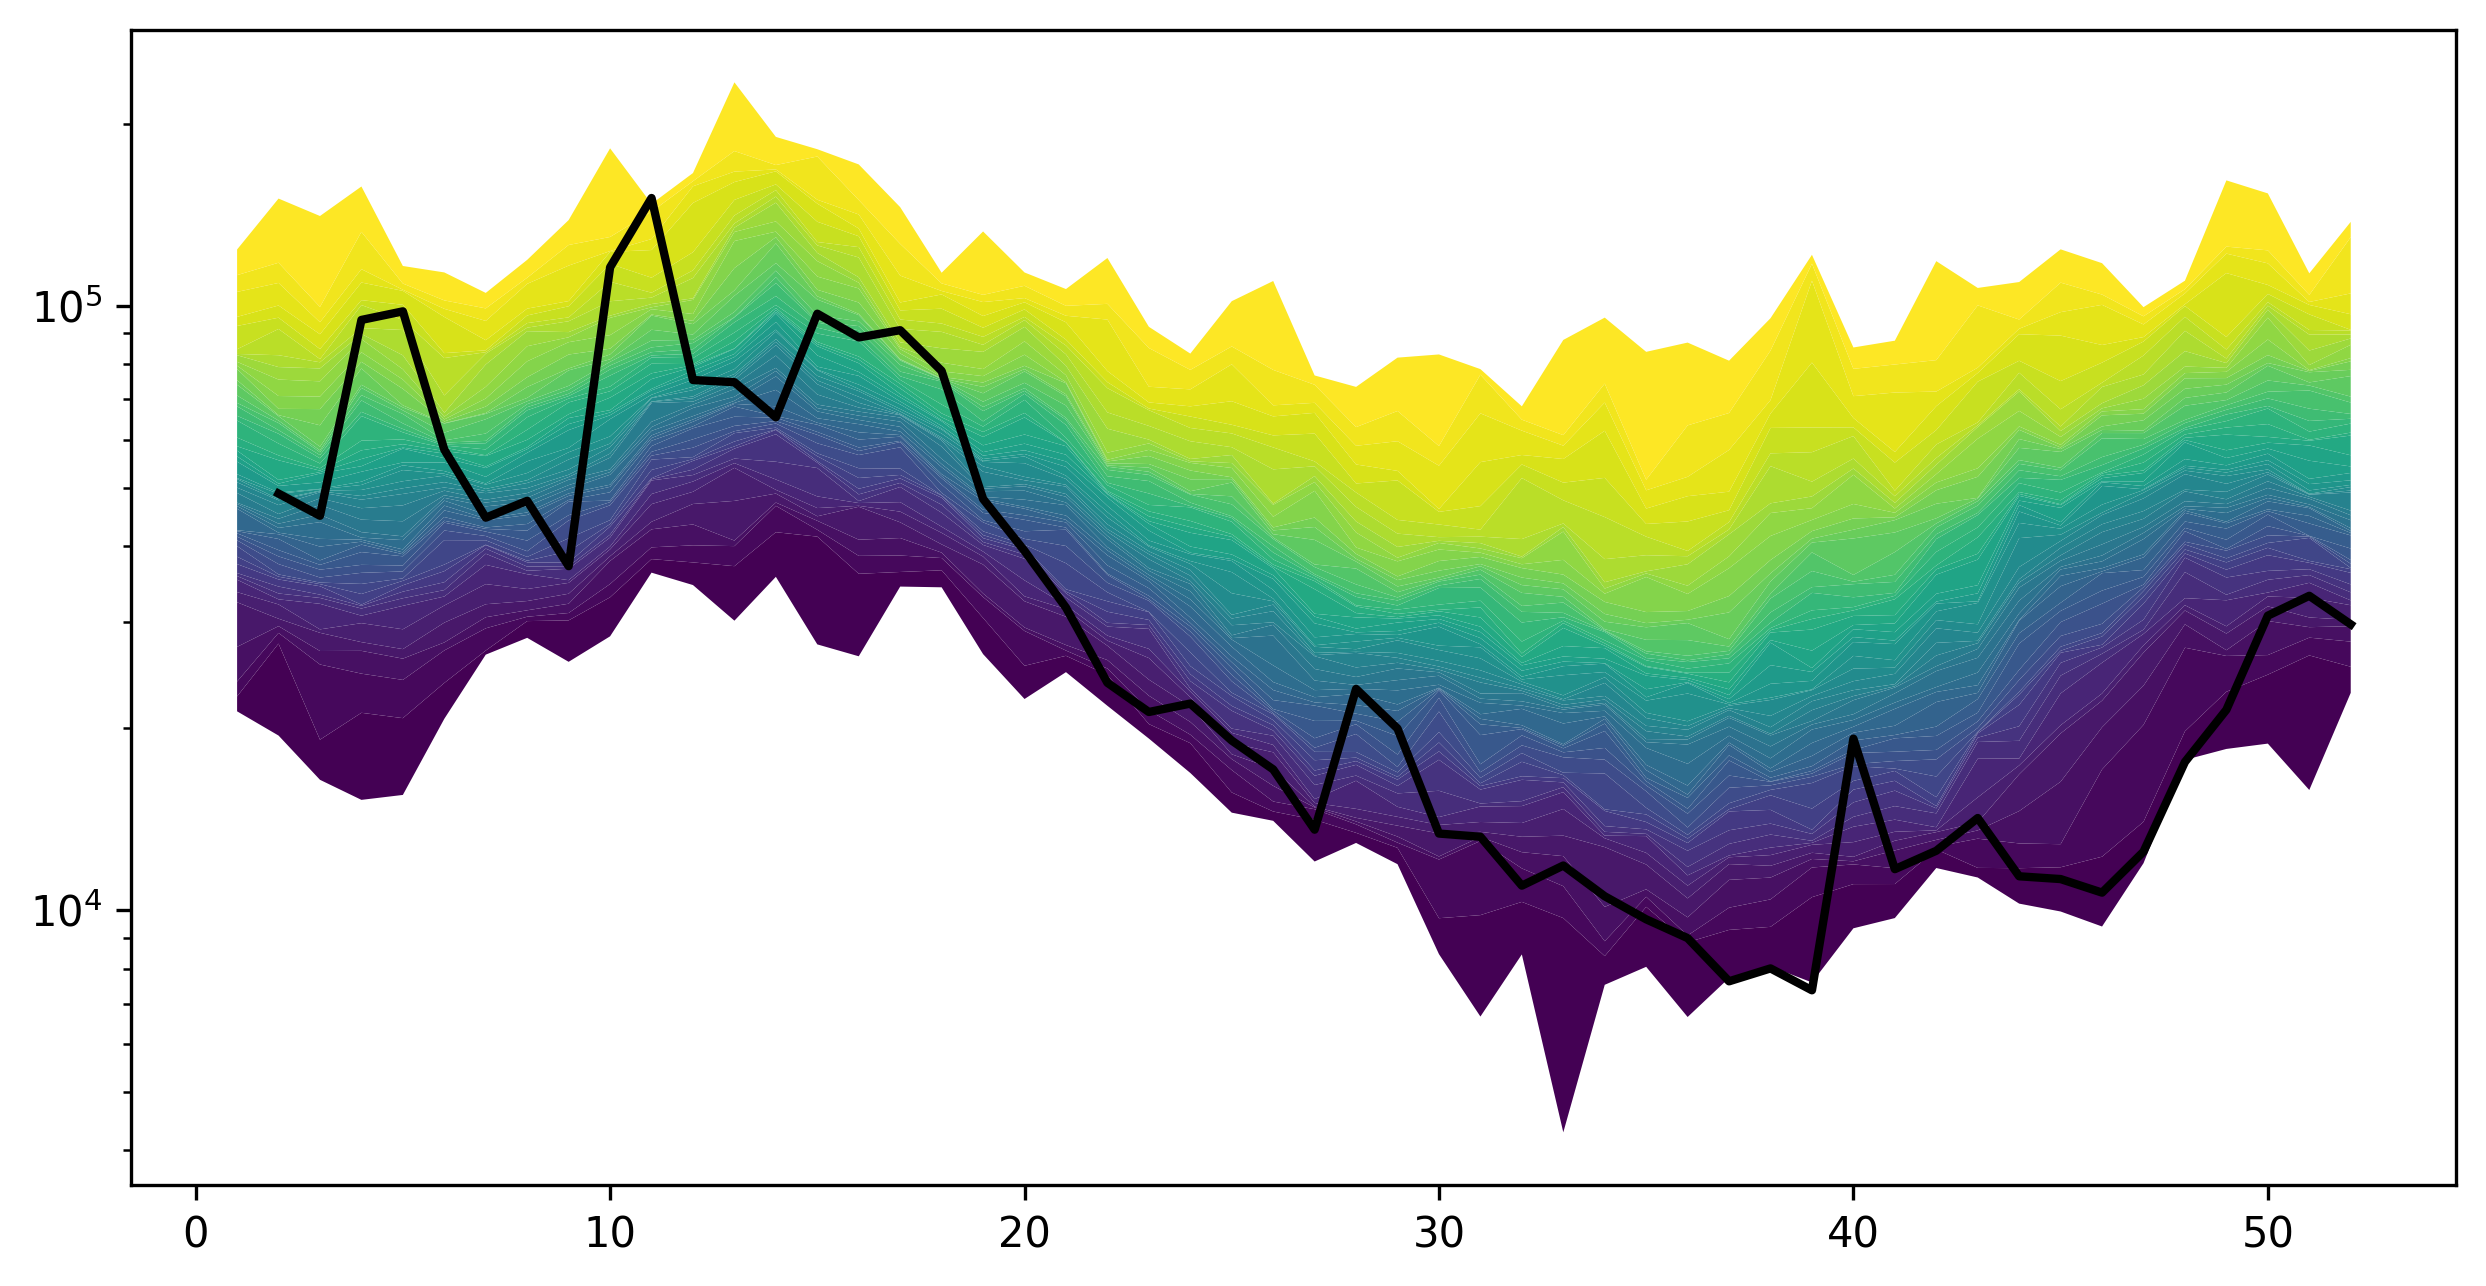

In [176]:

## New figure: Plot flow for 1 year of interest compared to 
## Weekly flow distributions acorss the year using a colormap
## Highlighting a single trace for a specific year

def plot_flow_distribution_with_highlight(Q, model,
                                          node,
                                          highlight_years,
                                          aggregation_length = 'W'):
    """
    Plot flow distribution for a single node
    """
    data = Q[model].copy()
    ## Aggregate dat
    data['TotalNYC'] = data[nyc_reservoirs].sum(axis=1)
    data = data.resample('W').sum()
    data.dropna(inplace=True)
    
    # Add column for week of year
    data['week'] = data.index.isocalendar().week
    
    # Calculate the percentiles - 5th, 25th, 50th, 75th, and 95th for the whole period
    percentiles = np.arange(0.1, 100, 2)
    perc_data = data.groupby('week')[node].quantile(np.array(percentiles)/100.0)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
    
    # Plot percentiles using colormap
    
    # Plot percentiles using colormap
    colors = plt.cm.viridis(np.linspace(0, 1, len(percentiles)-1))
    for i in range(len(percentiles)-1):
        p_lower = percentiles[i]/100.0
        p_upper = percentiles[i+1]/100.0
        lower = perc_data.loc[:, p_lower]
        upper = perc_data.loc[:, p_upper]    
        lower_values = np.nan_to_num(lower.values, nan=np.nanmean(lower.values))
        upper_values = np.nan_to_num(upper.values, nan=np.nanmean(upper.values))
        lower_values = lower_values[:-1]
        upper_values = upper_values[:-1]
        xs = np.arange(1, len(lower_values)+1)
        ax.fill_between(xs, lower_values, upper_values, 
                        color=colors[i], alpha=1, 
                        edgecolor='none')
    
    
    # Highlight the specific year with a black line
    for yr in highlight_years:
        # Extract the data for the year of interest
        year_data = data[node][data.index.year == yr]
        xs = year_data.index.isocalendar().week.values.tolist()
        xs = xs + [xs[-1]]
        xs = xs[1:]
        year_values = year_data.values.tolist()
        year_values = year_values + [year_values[-1]]
        year_values = year_values[1:]
        ax.plot(xs, year_values, 
                color='k', linewidth=2)
        
    
    plt.yscale('log')
    plt.show()
    return


plot_flow_distribution_with_highlight(Q, 'obs_pub_nwmv21_ObsScaled', 
                                      'delTrenton', 1964, aggregation_length='W')
    
    

In [174]:
Q['obs_pub_nwmv21_ObsScaled'].copy()

,cannonsville,pepacton,neversink,wallenpaupack,prompton,shoholaMarsh,mongaupeCombined,beltzvilleCombined,fewalter,merrillCreek,...,delMontague,01449800,01447800,delDRCanal,delTrenton,01463620,outletAssunpink,01470960,outletSchuylkill,TotalNYC
datetime,,,,,,,,,,,,,,,,,,,,,
1945-01-01,2738.362037,2117.905945,371.242675,446.395364,60.050223,306.216442,552.565723,88.215935,265.216491,1.921606,...,14194.339024,100.184717,298.679705,22369.453038,22369.453038,65.784030,241.247484,334.484014,3278.199685,5227.510658
1945-01-02,2422.756239,2127.027469,403.731308,564.626883,91.205907,276.568836,551.989582,125.222552,441.462462,1.989381,...,13773.547218,147.295292,510.839456,23866.097822,23866.097822,91.156590,307.641021,370.511968,3661.115478,4953.515016
1945-01-03,1641.654815,1267.740008,205.976903,435.897911,66.856382,175.778022,381.872496,99.700231,360.776901,1.285022,...,9938.127664,116.199543,407.528214,18787.826505,18787.826505,51.327944,190.279477,215.817213,2588.102495,3115.371725
1945-01-04,1237.335138,1001.179399,178.111844,376.138105,61.923730,129.293549,331.251656,96.854376,360.965806,1.139212,...,8403.486450,113.117529,406.549967,16198.393348,16198.393348,36.527240,144.234211,192.823765,2386.751240,2416.626381
1945-01-05,906.176179,757.490793,156.954206,301.984498,53.652545,95.995959,280.421265,92.484272,341.888748,0.912800,...,6705.065039,107.546763,383.206964,12650.326781,12650.326781,28.037949,116.940725,174.082766,2067.776394,1820.621178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,921.970254,620.575352,176.315581,257.477106,67.203806,80.292153,250.443589,146.853146,592.162701,0.684600,...,6124.298623,167.565812,656.819066,11486.282111,11486.282111,16.565244,90.540156,251.597925,1695.355830,1718.861187
2022-12-28,801.026966,538.592761,158.289699,232.562098,62.228139,69.658717,231.506168,136.010273,501.215685,0.684600,...,5331.545160,154.049038,555.035544,10325.927642,10325.927642,13.014474,87.701401,234.952412,1610.773410,1497.909426
2022-12-29,710.224623,478.663632,144.493837,215.206347,53.181473,62.620271,215.523494,126.843572,450.148655,0.684600,...,4757.149798,143.018143,497.563577,9500.783839,9500.783839,12.765680,87.158308,216.028722,1563.858778,1333.382093


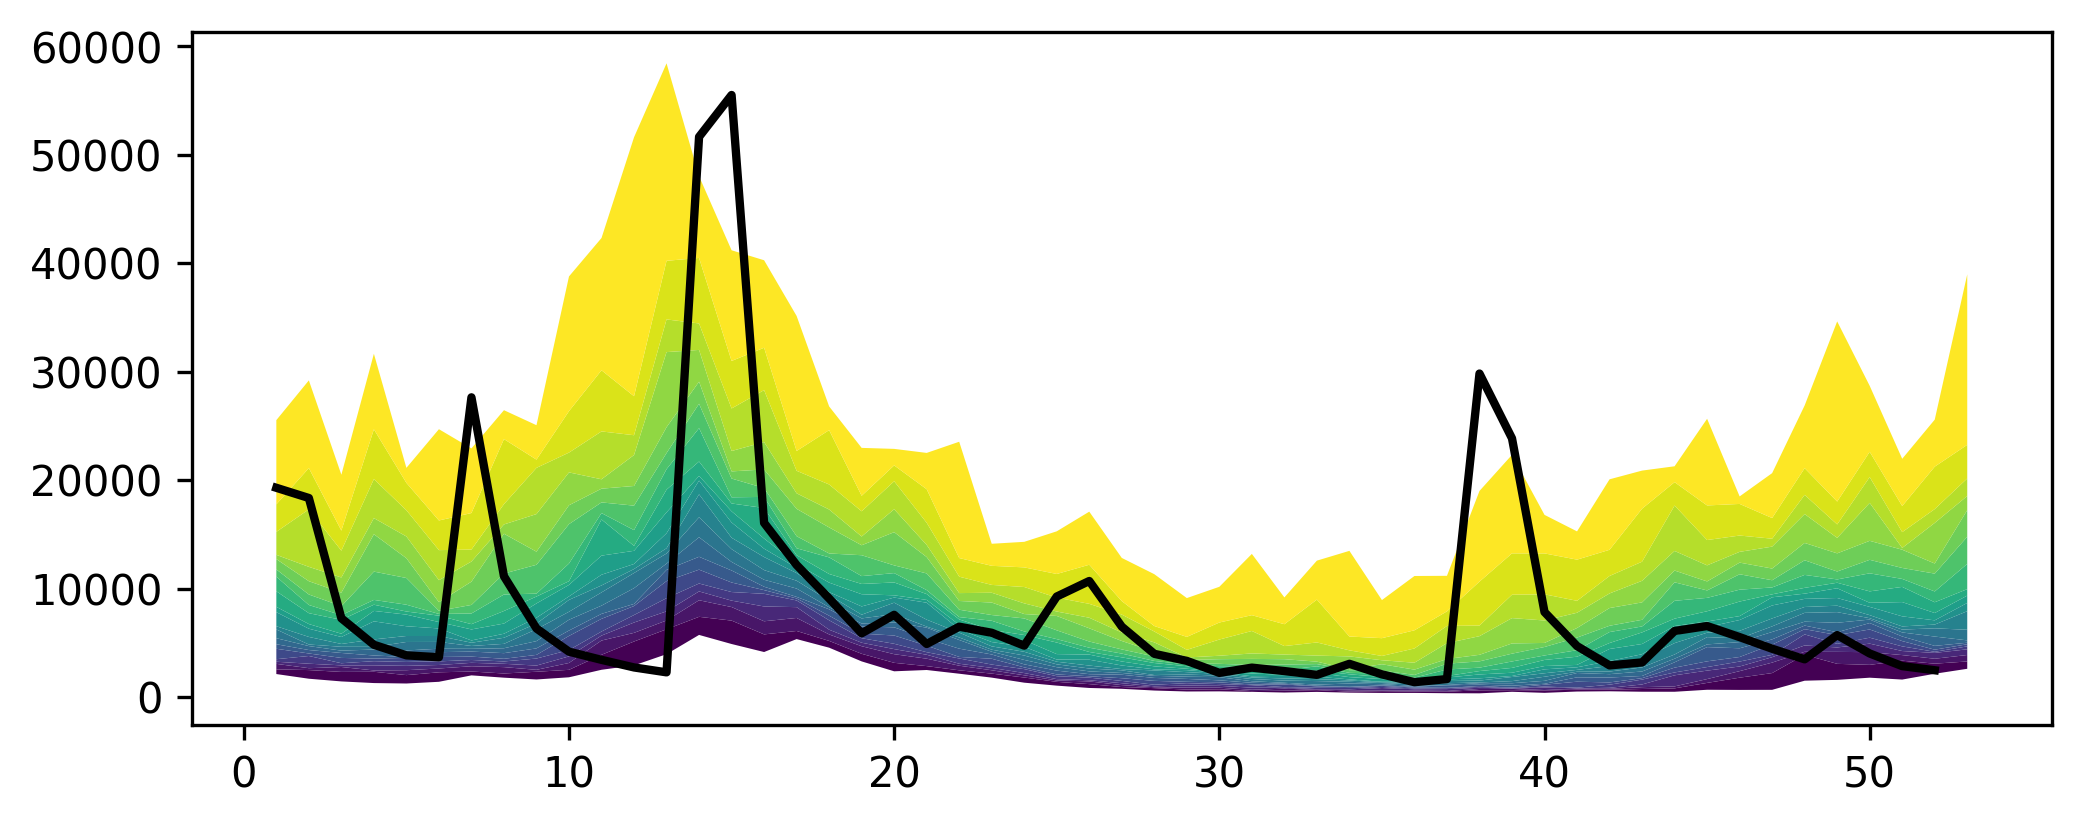

In [144]:
node = 'TotalNYC'
data['TotalNYC'] = data.loc[:, ['cannonsville', 'pepacton', 'neversink']].sum(axis=1)
data = data.copy()
data = data.resample('W').sum()
data.dropna(inplace=True)

# Add column for week of year
data['week'] = data.index.isocalendar().week

# Calculate the percentiles - 5th, 25th, 50th, 75th, and 95th for the whole period
percentiles = np.arange(1,100, 5)
perc_data = data.groupby('week')[node].quantile(np.array(percentiles)/100.0)

# Extract the data for the year of interest
year_data = data[node][data.index.year == 1960]

# Create the plot
fig, ax = plt.subplots(figsize=(8, 3), dpi=300)

# Plot percentiles using colormap

# Plot percentiles using colormap
colors = plt.cm.viridis(np.linspace(0, 1, len(percentiles)-1))
for i in range(len(percentiles)-1):
    p_lower = percentiles[i]/100.0
    p_upper = percentiles[i+1]/100.0
    lower = perc_data.loc[:, p_lower]
    upper = perc_data.loc[:, p_upper]
    # Ensure that the data values are finite by replacing NaNs or infs
    lower_values = np.nan_to_num(lower.values, nan=np.nanmean(lower.values))
    upper_values = np.nan_to_num(upper.values, nan=np.nanmean(upper.values))
    xs = np.arange(1, len(lower_values)+1)
    ax.fill_between(xs, lower_values, upper_values, 
                    color=colors[i], alpha=1, 
                    edgecolor='none')


# Highlight the specific year with a black line
ax.plot(np.arange(1, len(year_data)+1), year_data.values, 
        color='k', linewidth=2)


# plt.yscale('log')
plt.show()

In [143]:
data.loc[:, ['cannonsville', 'pepacton', 'neversink']].sum(axis=1)

datetime
1945-01-07    23099.899459
1945-01-14     7261.466921
1945-01-21     4248.603293
1945-01-28     3290.772853
1945-02-04     2662.807801
                  ...     
2022-12-04    18491.742574
2022-12-11    15883.502919
2022-12-18     8679.694097
2022-12-25    17559.722257
2023-01-01    11533.668009
Freq: W-SUN, Length: 4070, dtype: float64

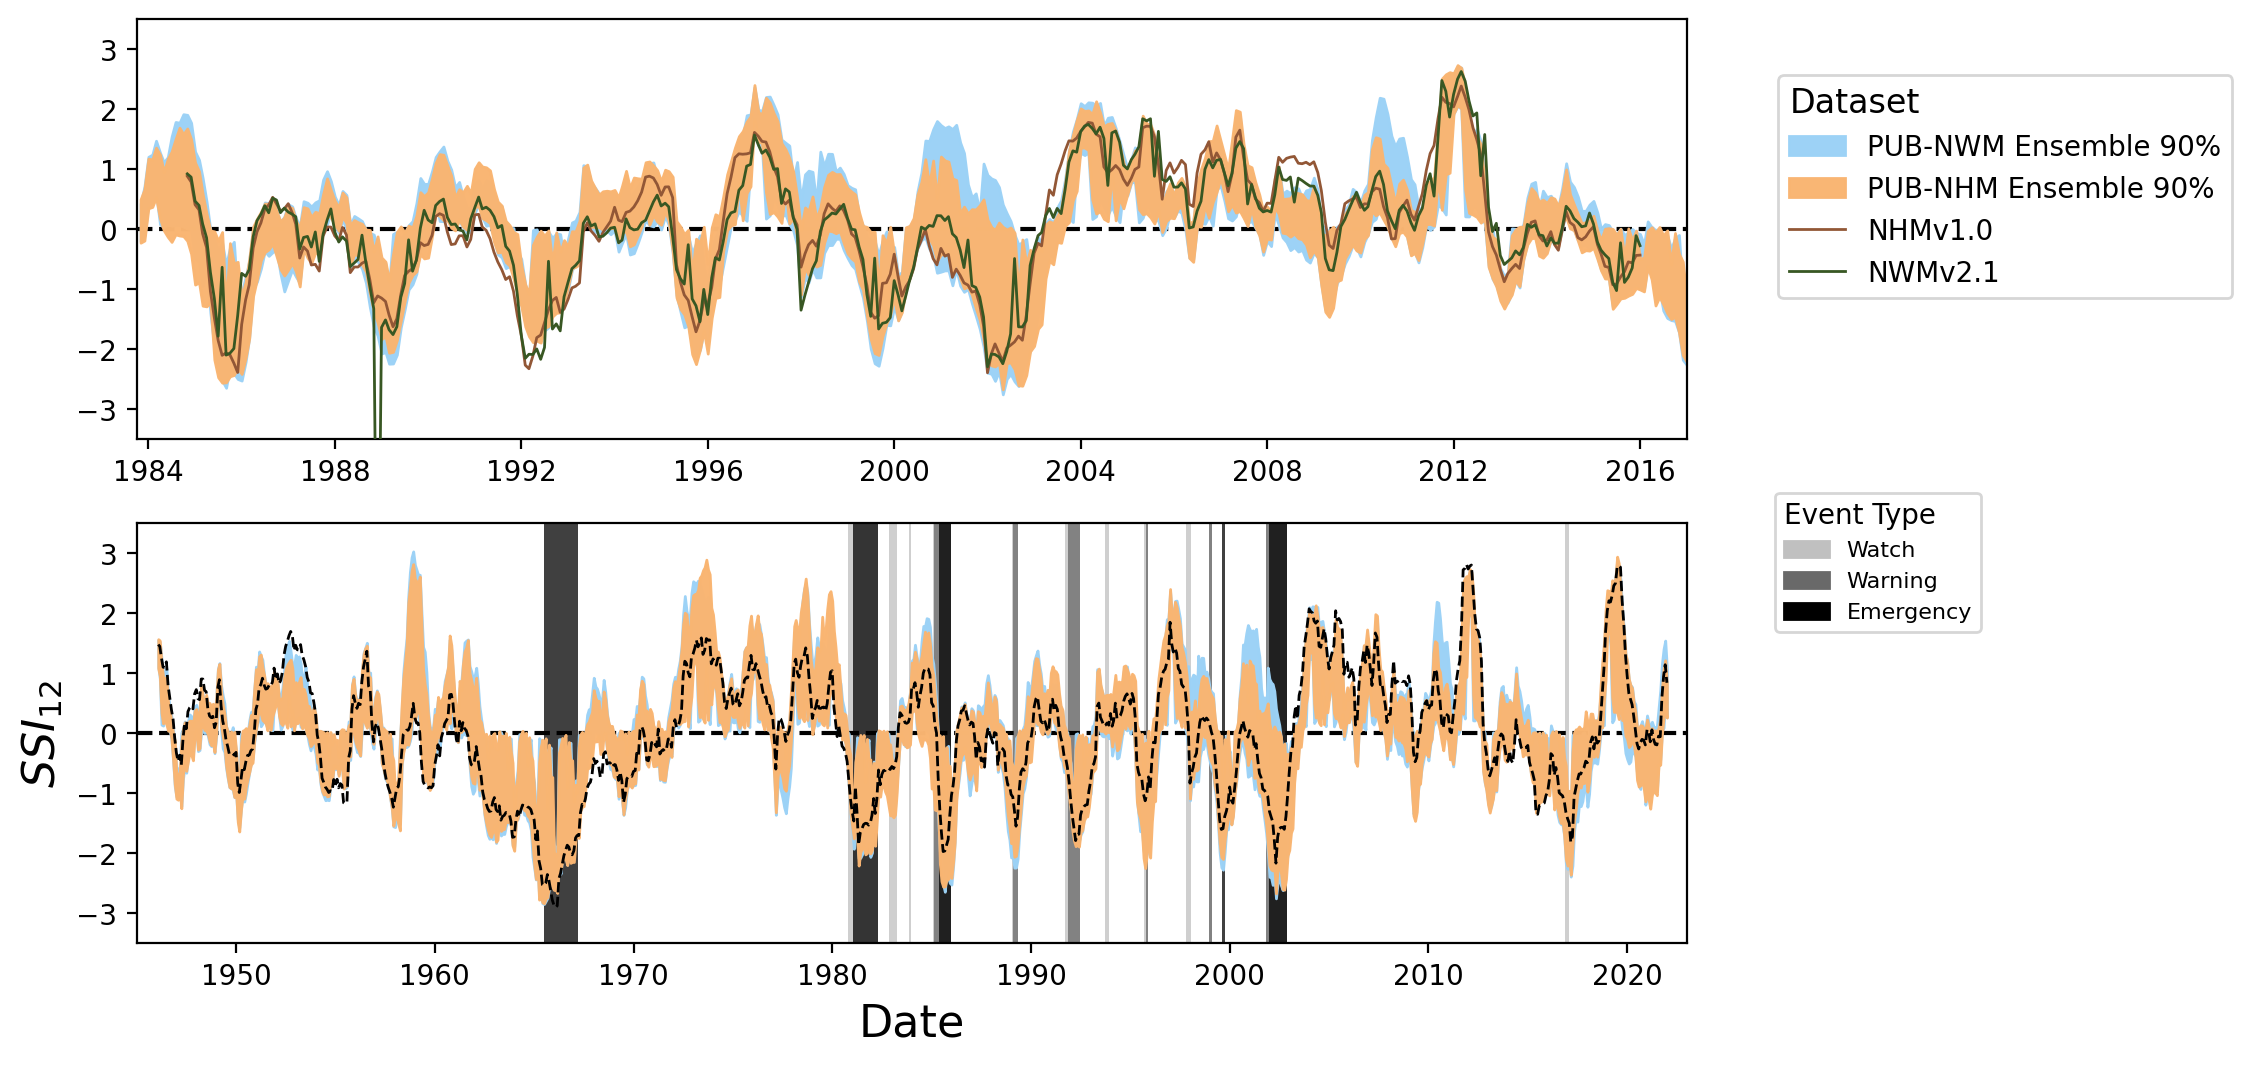

In [27]:


def plot_two_panel_ssi():
        # Specifications
    t_start='1983-10-01'
    t_end='2016-12-31'
    plot_nodes = ['delTrenton']
    transform_type = 'rolling'
    # transform_type = 'aggregation'
    window = 365
    aggregation_type = 'mean'
    aggregation_length = 'M' #'M'

    # Vertical lines at model start and end dates
    mod_ls = '--'
    mod_z = 0
    mod_lw=2
    mod_a =0.8
    mod_end_date = pd.to_datetime('2016-12-31') # if (m == 'nhmv10') else pd.to_datetime('2020-12-31')

    ### SSI-based droughts
    ssi_model_types = ['nhmv10', 'nwmv21', 
                    'obs_pub_nhmv10_ObsScaled_ensemble', 'obs_pub_nwmv21_ObsScaled_ensemble']

    # Define colors for different event types
    event_colors = {'Watch': 'silver', 
                    'Warning': 'dimgrey', 
                    'Emergency': 'black'}

    ax3_ymin = -3.15
    ax3_ymax = 3.15

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), dpi=200,
                                sharex=False, gridspec_kw={'height_ratios': [1,1]})

    ### SUBPLOT 1:  All models for overlap period (1983-10-01 to 2016-12-31)

    ### SUBPLOT 2: Just ob_pub ensemble for full period (1945-01-01 to 2022-12-31)
    band_ymax=3.5 
    band_ymin = 3.0
    ax1.hlines(y=0, xmin=pd.to_datetime('1983-10-01'), xmax=pd.to_datetime('2016-12-31'),
        color='k', lw=1.5, ls='--', zorder=0)
    
    for m in ['obs_pub_nwmv21_ObsScaled_ensemble', 'obs_pub_nhmv10_ObsScaled_ensemble']:                 
        for i, real_i in enumerate(ssi_d[m].keys()):
            ssi_instance = ssi_d[m][real_i].loc[:, plot_nodes[0]]
            Q_instance = Q[m][real_i].loc[:, plot_nodes[0]]

            
            if i == 0:
                ensemble_data = pd.DataFrame(ssi_instance, columns=[i], 
                                            index=ssi_instance.index)
            else:
                ensemble_data[i] = ssi_instance
            
            ensemble_data = ensemble_data.dropna(axis=1)
        

        #     plot_ssi_band(ssi_instance, 
        #         band_ymax, band_ymin, ax=ax2, 
        #         fill_color='maroon',
        #         alpha = 0.07)
        
        # Full period
        # Plot flow 90 quantile
        ax2.fill_between(x=ensemble_data.index,
                y1=ensemble_data.quantile(0.95, axis=1),
                y2=ensemble_data.quantile(0.05, axis=1),
                color=model_colors[m], 
                zorder=3,
                alpha=0.99, 
                interpolate=False)

        # Overlap period in ax1
        ensemble_data = ensemble_data.loc[t_start:t_end]
        ax1.fill_between(x=ensemble_data.index,
                y1=ensemble_data.quantile(0.95, axis=1),
                y2=ensemble_data.quantile(0.05, axis=1),
                color=model_colors[m], 
                edgecolor=model_colors[m],
                alpha=.99, 
                interpolate=False, 
                label = f'{model_labels[m]} 90%', zorder=2)


    for m in ['obs']: # ['obs_pub_nhmv10_ObsScaled', 'obs_pub_nwmv21_ObsScaled']:
        model_ls = '--' if m == 'obs' else '-'
        ssi_instance = ssi_d[m].loc[:, plot_nodes[0]]
        ax2.plot(ssi_instance,
                c=model_colors[m], label = model_labels[m],
                ls=model_ls,
                lw=1, zorder = 5)

    for m in ['nhmv10', 'nwmv21']: #, 'obs_pub_nhmv10_ObsScaled', 'obs_pub_nwmv21_ObsScaled']:
        model_ls = '--' if m == 'obs' else '-'
        ssi_instance = ssi_d[m].loc[t_start:t_end, plot_nodes[0]]
        ax1.plot(ssi_instance,
                c=model_colors[m], label = model_labels[m],
                ls=model_ls,
                lw=1, zorder = 5)
        
    for index, row in drbc_droughts.iterrows():
        color = event_colors[row['event_type']]
        start_date = pd.to_datetime(row['start_date'])
        end_date = pd.to_datetime(row['end_date'])
        ax2.axvspan(start_date, end_date,
                    ymin=0, ymax=1, 
                    facecolor=color, 
                    edgecolor='none', alpha=0.75, zorder=0)

    # Adding legend for the event types
    handles = [mpatches.Patch(color=color, label=event_type) for event_type, color in event_colors.items()]
    ax2.legend(handles=handles, loc='upper left', bbox_to_anchor=(1.05, 1.1), 
            title='Event Type', title_fontsize=10, fontsize=8, alignment='left')
    
    # Horizontal line at ssi 0
    ax2.hlines(y=0, 
               xmin=pd.to_datetime('1945-01-01'), xmax=pd.to_datetime('2022-12-31'),
               color='k', lw=1.5, ls='--', 
               zorder=1)

        
    ax1.set_xlim(pd.to_datetime(t_start), pd.to_datetime(t_end))
    ax2.set_xlim(pd.to_datetime('1945-01-01'), pd.to_datetime('2022-12-31'))
    ax1.set_ylim([-3.5,3.5])
    ax2.set_ylim([-3.5,3.5])
    ax2.set_ylabel(r'$SSI_{12}$', fontsize=16)
    ax2.grid(True, axis='y', which = 'minor', zorder=1)
    ax2.set_xlabel('Date', fontsize=16)
    ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 0.90), 
            title='Dataset', title_fontsize=12, fontsize=10, alignment='left')
    
    fig.align_ylabels()
    plt.show()
    return 

plot_two_panel_ssi()


In [27]:
# Modify basin geometries to not overlap
# update names to match pywr nodes
g1 = node_geoms
nodes = g1['node'].values
for i in range(len(nodes)):
    if nodes[i].split('_')[0]=='link':
        nodes[i] = nodes[i].split('_')[1]
g1['node'] = nodes

### subtract upstream catchments from mainstem nodes - note on a few occasions (eg pepacton & its gage), they are too close together and dont recognise a difference,so they disappear from this dataframe.
for node, upstreams in upstream_nodes_dict.items():
    for upstream in upstreams:
        overlay = g1.loc[g1['node'] == node].overlay(g1.loc[g1['node'] == upstream], how='difference')
        g1 = g1.loc[g1['node'] != node]
        g1 = pd.concat([g1, overlay])

g1.reset_index(inplace=True, drop=True)
g1['idx'] = list(g1.index)



c:\Users\tjame\Desktop\Research\DRB\Pywr-DRB\DRB-Historic-Reconstruction\venv\lib\site-packages\geopandas\geodataframe.py:2452: UserWarning: `keep_geom_type=True` in overlay resulted in 37 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(
c:\Users\tjame\Desktop\Research\DRB\Pywr-DRB\DRB-Historic-Reconstruction\venv\lib\site-packages\geopandas\geodataframe.py:2452: UserWarning: `keep_geom_type=True` in overlay resulted in 24 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(
c:\Users\tjame\Desktop\Research\DRB\Pywr-DRB\DRB-Historic-Reconstruction\venv\lib\site-packages\geopandas\geodataframe.py:2452: UserWarning: `keep_geom_type=True` in overlay resulted in 24 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


,node,lat,long,comid,geometry,idx
0,cannonsville,42.065872,-75.37462,2614136,"POLYGON ((-75.25965 42.07860, -75.25913 42.075...",0


In [12]:
def plot_ssi_band(ssi, ymax, ymin, ax = None, 
                  fill_color = 'grey',
                  alpha = 0.75):
    """Plot the standardized index values as a time series. 
    Modified from https://github.com/martinvonk/SPEI/blob/main/src/spei/plot.py

    Parameters
    ----------
    si : pandas.Series
        Series of the standardized index
    bound : int, optional
        Maximum and minimum ylim of plot
    figsize : tuple, optional
        Figure size, by default (8, 4)
    ax : matplotlib.Axes, optional
        Axes handle, by default None which create a new axes

    Returns
    -------
    matplotlib.Axes
        Axes handle
    """

    # Classify droughts
    in_critical_drought = False
    droughts = np.zeros_like(ssi.values)
    drought_days = []
    for ind in range(len(droughts)):
        if ssi.values[ind] < 0:
            drought_days.append(ind)
            
            if ssi.values[ind] <= -1:
                in_critical_drought = True
            
        else:
            if in_critical_drought:
                droughts[drought_days] =1
            in_critical_drought = False
            drought_days = [] 
    
    # Handle edge case
    if in_critical_drought:
        droughts[drought_days] =1
        
        
    ax.fill_between(x=ssi.index, y1=ymax, y2=ymin, 
                    where=(droughts>0), color=fill_color, alpha=alpha, 
                    zorder=2,
                    interpolate=False)
    return ax



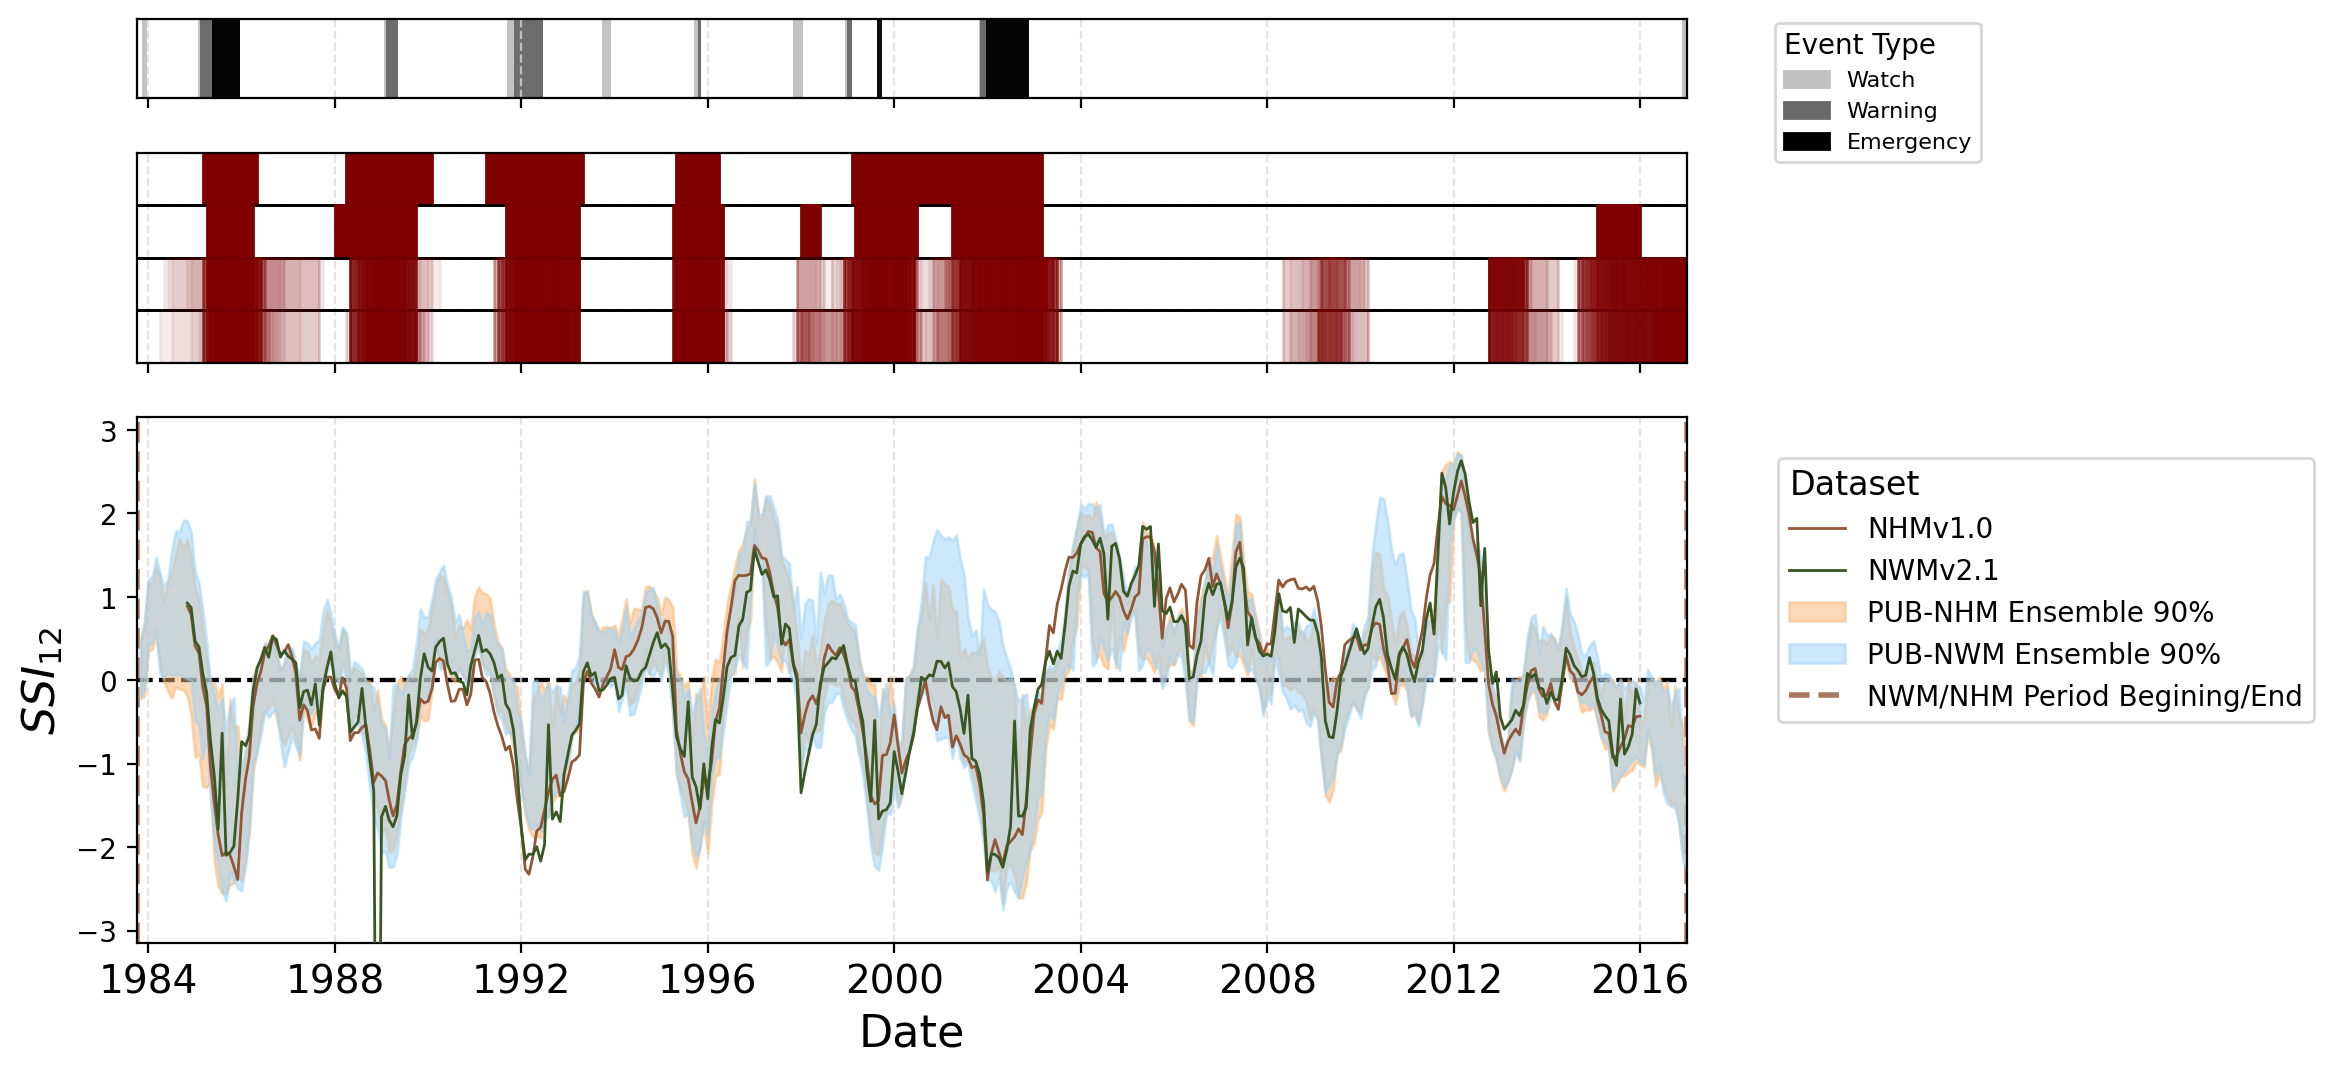

In [28]:
# Specifications
t_start='1983-10-01'
t_end='2016-12-31'
plot_nodes = ['delTrenton']
transform_type = 'rolling'
# transform_type = 'aggregation'
window = 365
aggregation_type = 'mean'
aggregation_length = 'M' #'M'

# Define colors for different event types
event_colors = {'Watch': 'silver', 
                'Warning': 'dimgrey', 
                'Emergency': 'black'}

ax3_ymin = -3.15
ax3_ymax = 3.15

# Create a figure with two subplots
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10, 6), dpi=200,
                               sharex=True, gridspec_kw={'height_ratios': [0.75, 2,5]})

## DRBC-classified drought events
# Iterate through the events and create colored bars
for index, row in drbc_droughts.iterrows():
    color = event_colors[row['event_type']]
    start_date = pd.to_datetime(row['start_date'])
    end_date = pd.to_datetime(row['end_date'])
    ax1.axvspan(start_date, end_date, facecolor=color, edgecolor='none', alpha=0.95)

# Adding legend for the event types
handles = [mpatches.Patch(color=color, label=event_type) for event_type, color in event_colors.items()]
ax1.legend(handles=handles, loc='upper left', bbox_to_anchor=(1.05, 1.1), 
           title='Event Type', title_fontsize=10, fontsize=8, alignment='left')
# ax1.set_ylabel('DRBC\nDroughts', fontsize=14)
ax1.set_yticks([])

### SSI-based droughts
ssi_model_types = ['nhmv10', 'nwmv21', 
                   'obs_pub_nhmv10_ObsScaled_ensemble', 'obs_pub_nwmv21_ObsScaled_ensemble']
for i, m in enumerate(ssi_model_types):
    band_ymax= 1 - i / len(ssi_model_types)
    band_ymin = band_ymax - 1 / len(ssi_model_types)
    band_xmin = pd.to_datetime(t_start) if ('obs_pub' in m) else pd.to_datetime('1983-10-01')
    band_xmax = pd.to_datetime(t_end) if ('obs_pub' in m) else pd.to_datetime('2016-12-30')
    

    ax2.hlines(y=band_ymin, xmin=band_xmin, xmax=band_xmax,
                color='k', lw=1)
    if i > 0:
        ax2.hlines(y=band_ymax, xmin=pd.to_datetime(t_start), xmax=pd.to_datetime(t_end),
                lw=1, ls='--', color='k', zorder=0)
        ax2.hlines(y=band_ymax, xmin=band_xmin, xmax=band_xmax,
                color='k', lw=1)
    
    # ax2.vlines(x=band_xmin, ymin=band_ymin, ymax=band_ymax, lw=1.5, color='k')
    # ax2.vlines(x=band_xmax, ymin=band_ymin, ymax=band_ymax, lw=1.5, color='k')
    
    
    if 'ensemble' in m:
        
        
        for i, real_i in enumerate(ssi_d[m].keys()):
            ssi_instance = ssi_d[m][real_i].loc[t_start:t_end, plot_nodes[0]]
            Q_instance = Q[m][real_i].loc[ssi_instance.index, plot_nodes[0]]
            
            plot_ssi_band(ssi_instance, 
                          band_ymax, band_ymin, ax=ax2, 
                          fill_color='maroon',
                          alpha = 0.07)
            
            if i == 0:
                ensemble_data = pd.DataFrame(ssi_instance, columns=[i], 
                                            index=ssi_instance.index)
            else:
                ensemble_data[i] = ssi_instance
            
            ensemble_data = ensemble_data.dropna(axis=1)
        
        # ensemble_data = transform_flow(ensemble_data, transform = transform_type,
        #                                window=window, aggregation_type = aggregation_type,
        #                                aggregation_length = aggregation_length)       
            
        # Plot flow 90 quantile
        ax3.fill_between(x=ensemble_data.index,
                        y1=ensemble_data.quantile(0.95, axis=1),
                        y2=ensemble_data.quantile(0.05, axis=1),
                        color=model_colors[m], alpha=0.5, 
                        interpolate=False, 
                        label = f'{model_labels[m]} 90%', zorder=2)
        

    else:
        if m in ['nhmv10', 'nwmv21']:
            plot_ssi_band(ssi_d[m].loc[t_start:t_end, plot_nodes[0]], 
                        band_ymax, band_ymin, ax=ax2, alpha =1,
                        fill_color = 'maroon')

        ## Plot ssi

        ax3.plot(ssi_d[m].loc[t_start:t_end, plot_nodes[0]],
                 c=model_colors[m], label = model_labels[m],
                 lw=1, zorder = 5)
  
  
        # Horizontal line at ssi 0
        ax3.hlines(y=0, xmin=pd.to_datetime(t_start), xmax=pd.to_datetime(t_end),
                    color='k', lw=1.5, ls='--', zorder=0)



# Vertical lines at model start and end dates
mod_ls = '--'
mod_z = 0
mod_lw=2
mod_a =0.8
mod_end_date = pd.to_datetime('2016-12-31') # if (m == 'nhmv10') else pd.to_datetime('2020-12-31')

# ax2.vlines(x=pd.to_datetime('1983-10-01'), ymin=0.5, ymax=1,
#         lw=mod_lw, color=model_colors['nhmv10'], zorder= mod_z,
#         ls=mod_ls, alpha=mod_a)
# ax2.vlines(x=mod_end_date, ymin=0.5, ymax=1,
#         lw=mod_lw, color=model_colors['nhmv10'], zorder=mod_z, 
#         ls=mod_ls, alpha=mod_a)

    
ax3.vlines(x=pd.to_datetime('1983-10-01'), ymin=ax3_ymin, ymax=ax3_ymax, 
        lw=mod_lw, color=model_colors['nhmv10'], zorder= mod_z,
        ls=mod_ls, alpha=mod_a)


ax3.vlines(x=mod_end_date, ymin=ax3_ymin, ymax=ax3_ymax, 
        lw=mod_lw, color=model_colors['nhmv10'], zorder=mod_z, 
        ls=mod_ls,
        label=f'NWM/NHM Period Begining/End', alpha=mod_a)



# ax3.set_yscale('log')
ax2.set_ylim([0,1])
ax2.set_yticklabels([])
ax2.set_yticks([])


ax3.set_ylim([ax3_ymin, ax3_ymax])
ax3.set_ylabel(r'$SSI_{12}$', fontsize=16)
ax3.grid(True, axis='y', which = 'minor', zorder=1)

ax1.grid(True, axis='x', which = 'major', zorder=0, ls='--', color='gainsboro', alpha=0.75)
ax2.grid(True, axis='x', which = 'major', zorder=0, ls='--', color='gainsboro', alpha=0.75)
ax3.grid(True, axis='x', which = 'major', zorder=0, ls='--', color='gainsboro', alpha=0.75)

ax3.legend(loc='upper left', bbox_to_anchor=(1.05, 0.95), 
           title='Dataset', title_fontsize=12, fontsize=10, alignment='left')
plt.xlabel('Date', fontsize=16)
plt.xticks(fontsize=14)
plt.xlim(pd.to_datetime(t_start), pd.to_datetime(t_end))
# plt.ylabel(f'SSI-{int(window/29)}', fontsize=14)
fig.align_ylabels()
# ax2.legend()
plt.show()


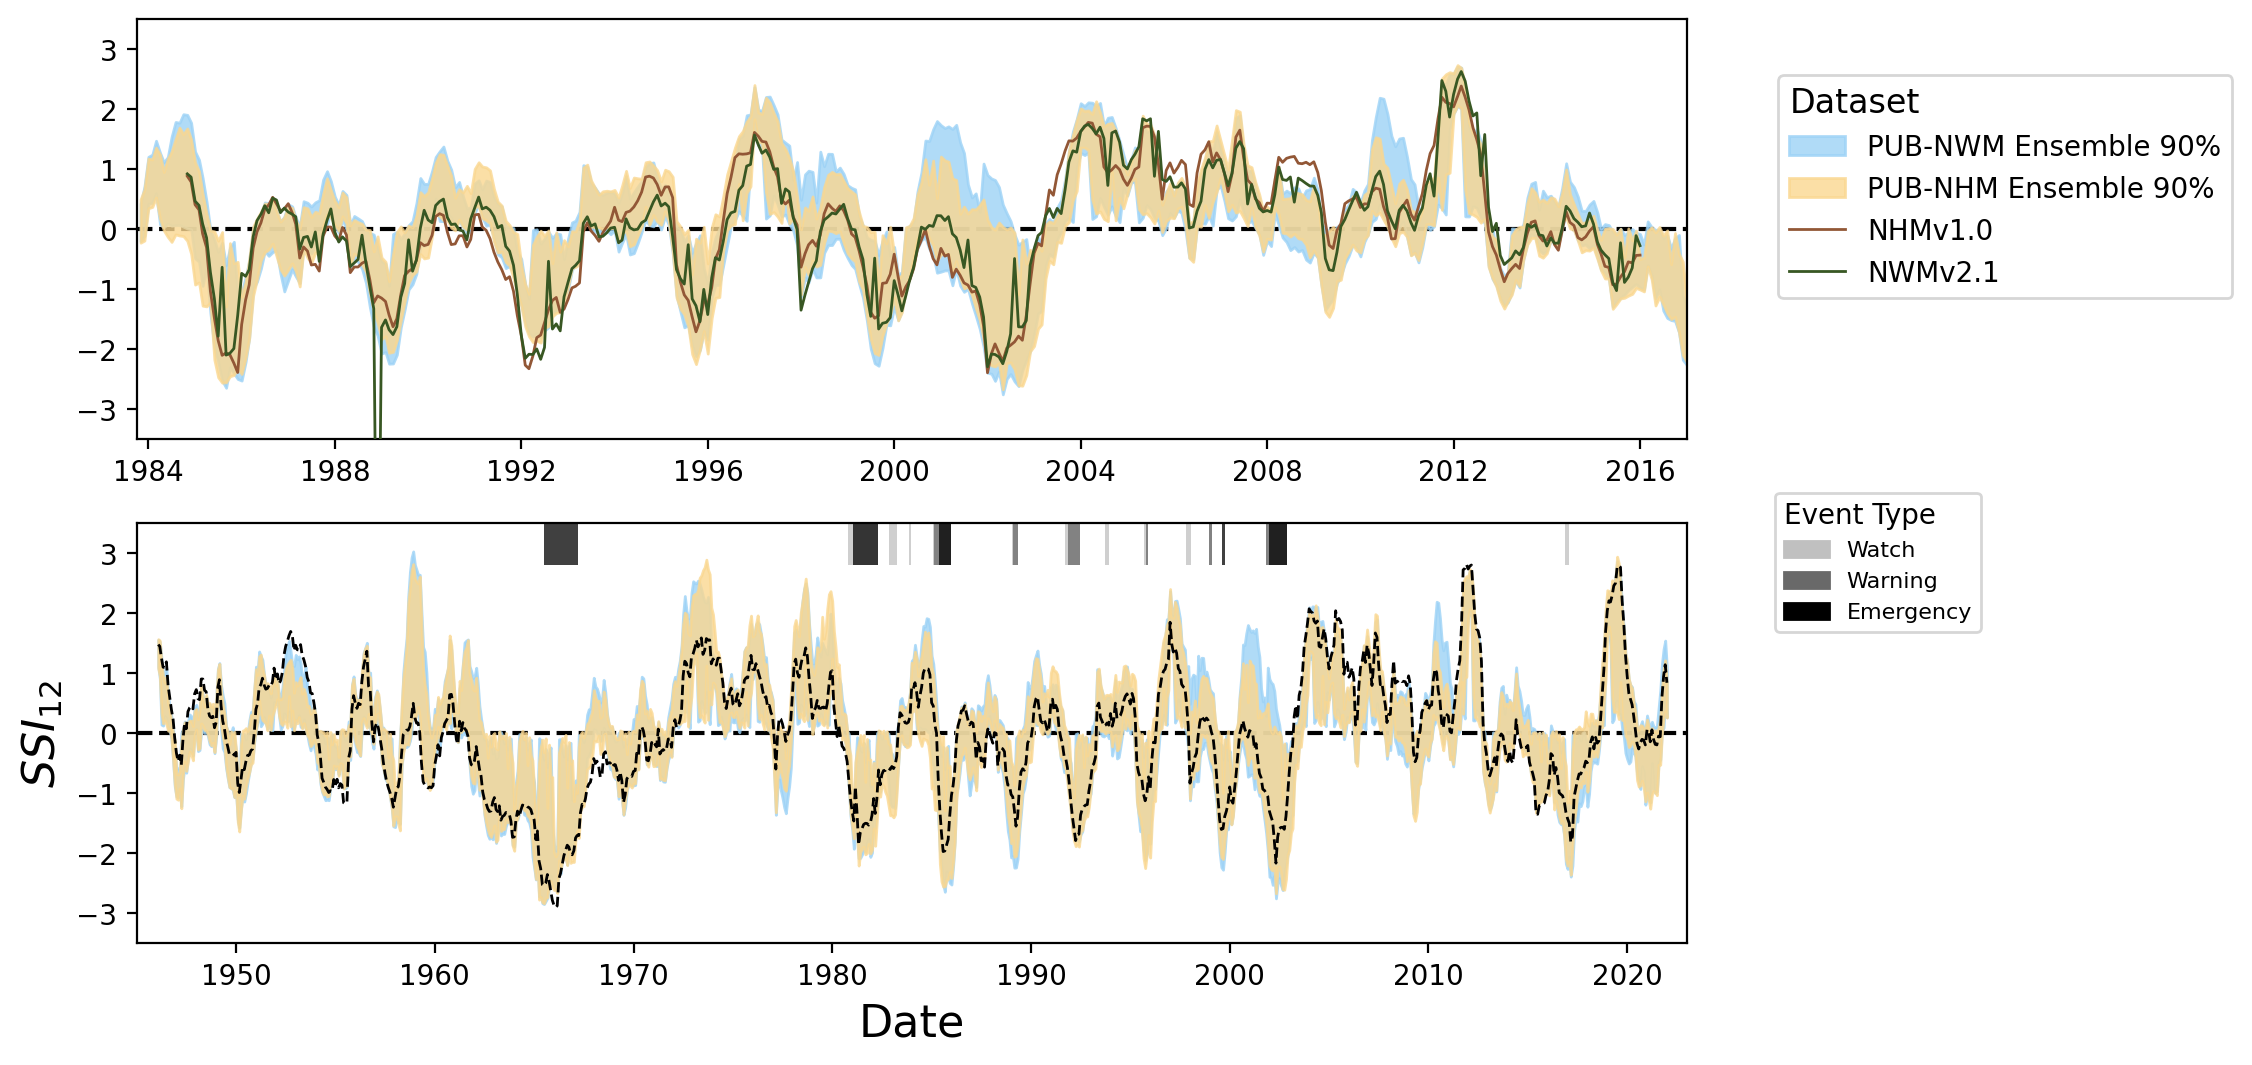

In [15]:
ssi_d['nwmv21'].min

<bound method NDFrame._add_numeric_operations.<locals>.min of             delTrenton
datetime              
1984-10-31    0.926664
1984-11-30    0.871776
1984-12-31    0.471780
1985-01-31    0.400244
1985-02-28    0.094693
...                ...
2015-08-31   -0.883118
2015-09-30   -0.794471
2015-10-31   -0.639995
2015-11-30   -0.103141
2015-12-31   -0.270242

[375 rows x 1 columns]>

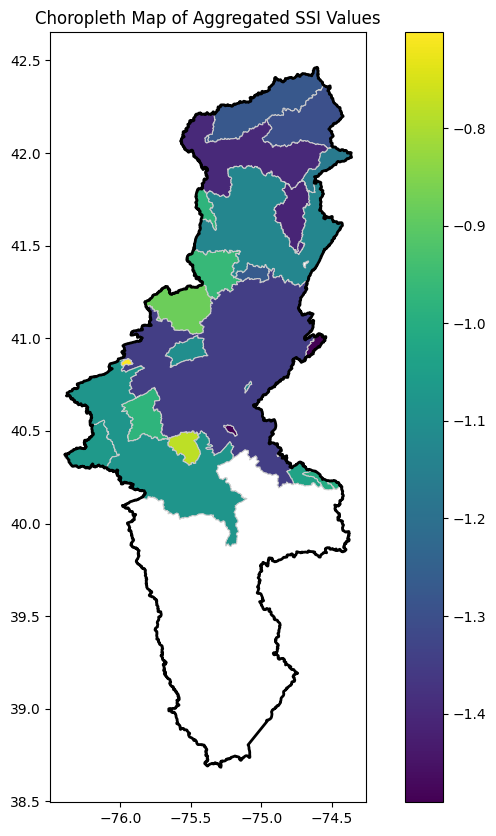

In [32]:
def plot_choropleth(node_basins, ssi, 
                    time_range=('1960-01-01', '2010-12-31'),
                    drb_boundary = None,
                    aggregation_method='mean'):
    aggregation_method_options = ['mean', 'min']
    
    # Aggregate the SSI values over the given time range
    ssi = ssi.loc[time_range[0]:time_range[1],:]
    if aggregation_method == 'mean':
        agg_ssi = ssi.mean().reset_index()
    elif aggregation_method == 'min':
        agg_ssi = ssi.min().reset_index()
    agg_ssi.columns = ['node', 'ssi']
    
    # Prepare a DataFrame for merging with node_basins
    merged = node_basins.merge(agg_ssi, on ='node')
    
    # Create the Choropleth figure
    fig, ax = plt.subplots(figsize=(10, 10))
    merged.plot(column='ssi', cmap='viridis', # vmax=0, vmin=-2, 
                linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
    if drb_boundary is not None:
        drb_boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=2)

    plt.title('Choropleth Map of Aggregated SSI Values')
    plt.show()
    
    return

plot_choropleth(node_basins, ssi_nhmv10, drb_boundary=drb_boundary, time_range=('1985-02-22',	'1986-04-26'))

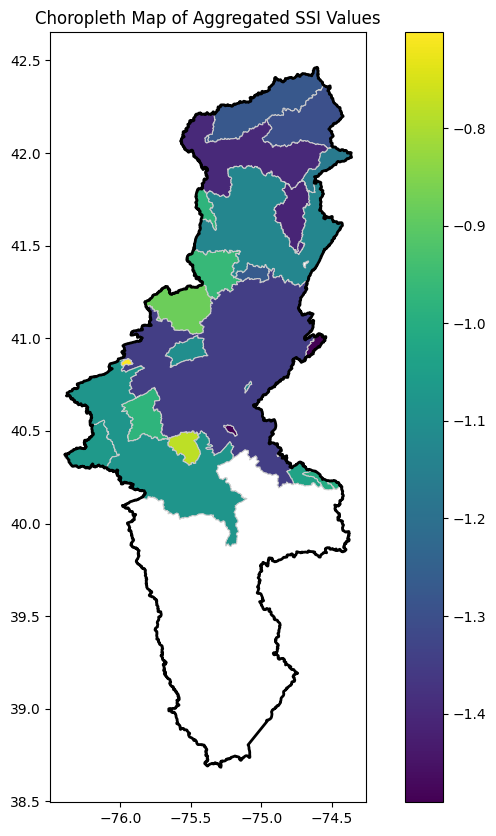

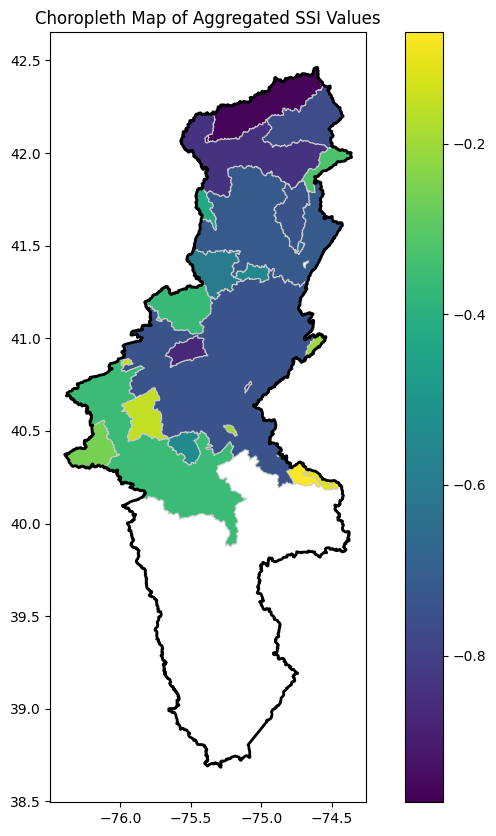

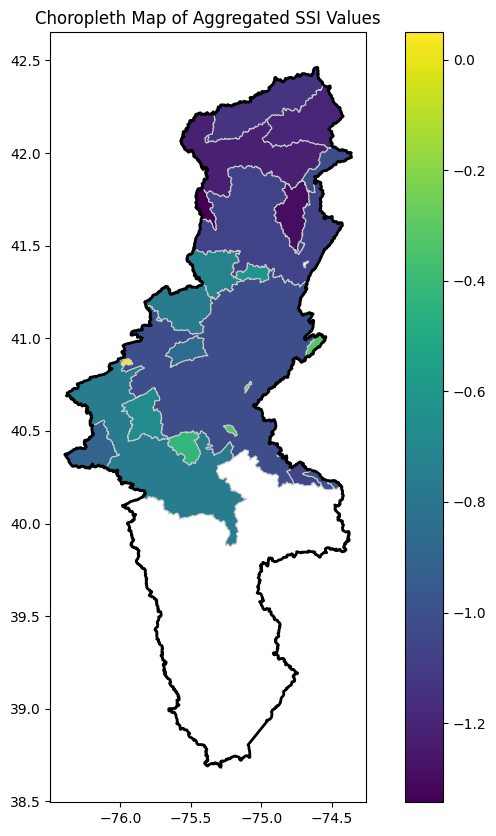

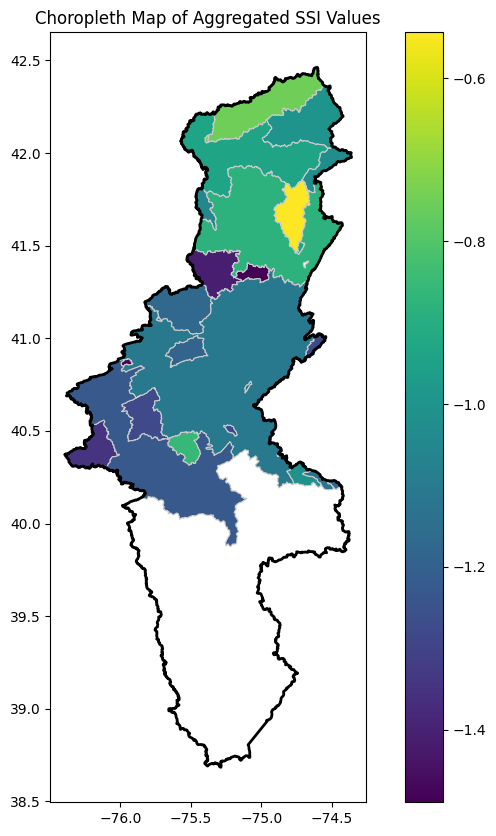

In [34]:
drought_metrics.loc[drought_metrics['node']=='delTrenton']


plot_choropleth(node_basins, ssi_nhmv10, drb_boundary=drb_boundary, time_range=('1985-02-22',	'1986-04-26'))

plot_choropleth(node_basins, ssi_nhmv10, drb_boundary=drb_boundary, time_range=('1988-03-01',	'1990-02-07'))
plot_choropleth(node_basins, ssi_nhmv10, drb_boundary=drb_boundary, time_range=('1995-04-14',	'1996-04-18'))
plot_choropleth(node_basins, ssi_nhmv10, drb_boundary=drb_boundary, time_range=('2000-09-17', '2003-03-24'))

In [1]:
ssi_d

NameError: name 'ssi_d' is not defined

In [31]:
ssi_d['nhmv10']

,delTrenton
datetime,
1984-10-31,0.887851
1984-11-30,0.792328
1984-12-31,0.412629
1985-01-31,0.326280
1985-02-28,-0.071212
...,...
2015-08-31,-0.703354
2015-09-30,-0.540738
2015-10-31,-0.557081


In [38]:
plot_nodes = ['Total NYC', 'blueMarsh', 'beltzvilleCombined']
plot_nodes = nyc_reservoirs
plot_nodes= ['delTrenton']
ssi = ssi_d['obs_pub_nhmv10_ObsScaled'].loc[:, plot_nodes]

drought_data = {}
drought_counter = 0
for node in ssi.columns:
    node_ssi = ssi[node]
    in_drought = False
    in_critical_drought = False

    drought_days = []

    for ind in range(len(ssi)):
        if node_ssi.values[ind] < 0:
            in_drought = True
            drought_days.append(ind)
            
            if node_ssi.values[ind] <= -1:
                in_critical_drought = True
        else:
            # Record drought info once it ends
            if in_critical_drought:
                drought_counter += 1
                drought_data[drought_counter] = {
                    'start':node_ssi.index[drought_days[0]],
                    'end': node_ssi.index[drought_days[-1]],
                    'duration': len(drought_days),
                    'magnitude': sum(node_ssi.values[drought_days]),
                    'severity': min(node_ssi.values[drought_days]),
                    'node': node
                }
                
            in_drought = False
            in_critical_drought = False
            drought_days = [] 

drought_metrics = pd.DataFrame(drought_data).transpose()

drought_metrics.head()


,start,end,duration,magnitude,severity,node
1,1949-06-30,1950-08-31,15,-7.37053,-1.212062,delTrenton
2,1957-06-30,1958-04-30,11,-8.230912,-1.203013,delTrenton
3,1962-06-30,1967-11-30,66,-81.46116,-2.615742,delTrenton
4,1968-08-31,1970-03-31,20,-9.18607,-1.008286,delTrenton
5,1980-09-30,1983-04-30,32,-30.93361,-1.816531,delTrenton


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


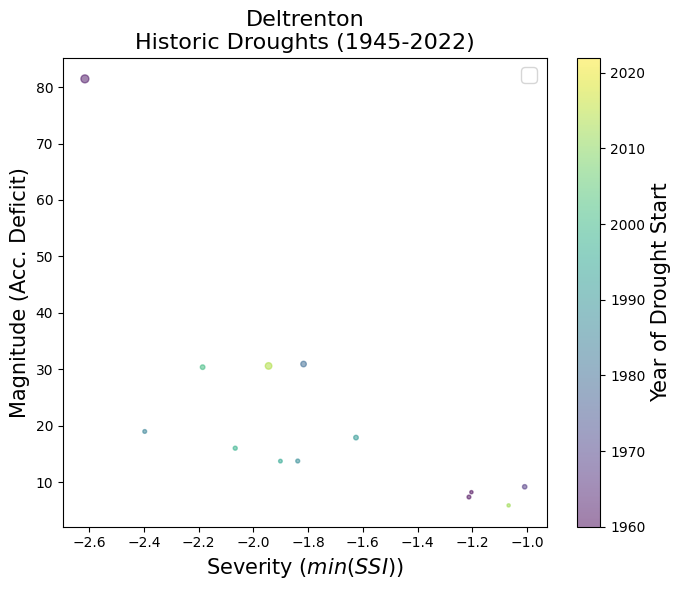

In [39]:
## Options

marker_keys = {'NYC Reservoirs' : 'o',
               'Upper Basin Reservoirs' : "^",
               'Mid-Basin Reservoirs' : 'D',
               'Lower Basin Reservoirs': "v"}


highlight_after_1970 = False
color_by_metric = 'date'
size_by_metric = 'duration'
plot_nodes = ['delTrenton']

fig, ax = plt.subplots(figsize = (7,6))

# Loop through nodes
for node in plot_nodes:
    node_drought_metrics = drought_metrics[drought_metrics['node']==node]
    xs = node_drought_metrics['severity']
    ys = -node_drought_metrics['magnitude']

    if color_by_metric == 'duration':
        marker_colors = node_drought_metrics[color_by_metric]
    elif color_by_metric == 'date':
        marker_colors = pd.to_datetime(node_drought_metrics['start']).dt.year

    # Assign marker shape
    if node in nyc_reservoirs:
        marker_shape = marker_keys['NYC Reservoirs']
    # elif node in upper_basin_reservoirs:
    #     marker_shape = marker_keys['Upper Basin Reservoirs']
    # elif node in mid_basin_reservoirs:
    #     marker_shape = marker_keys['Mid-Basin Reservoirs']
    # elif node in lower_basin_reservoirs:
    #     marker_shape = marker_keys['Lower Basin Reservoirs']
    else: 
        marker_shape = 'o'

    marker_sizes = node_drought_metrics[size_by_metric].values/2 if size_by_metric else 100
    marker_sizes = list(marker_sizes)

    p = ax.scatter(xs, ys,
                s = marker_sizes,
                marker=marker_shape,
                c=marker_colors, vmin=1960, vmax=2022, 
                alpha = 0.5)


if color_by_metric:
    plt.colorbar(p).set_label(label = 'Year of Drought Start',size=15)
plt.xlabel(r'Severity ($min(SSI)$)', fontsize = 15)
plt.ylabel(r'Magnitude (Acc. Deficit)', fontsize = 15)
if len(plot_nodes) == 1:
    plt.title(f'{plot_nodes[0].capitalize()}\nHistoric Droughts (1945-2022)', fontsize = 16)
else:
    plt.title(f'DRB Historic Droughts (1945-2022)', fontsize = 16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()


In [37]:
node_drought_metrics

,start,end,duration,magnitude,severity,node
1,1985-02-28,1986-04-30,15,-19.611804,-2.384277,delTrenton
2,1988-03-31,1990-01-31,23,-17.754356,-1.621214,delTrenton
3,1991-03-31,1993-04-30,26,-29.805449,-2.321172,delTrenton
4,1995-04-30,1996-03-31,12,-12.663052,-1.705925,delTrenton
5,1999-01-31,2003-02-28,50,-48.997802,-2.389131,delTrenton
